Email spam detection

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing utilities
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # for handling imbalance

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pickle

In [2]:
df = pd.read_csv("spam_ham_dataset.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
df.shape 

(5171, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
df.sample(3)

,Unnamed: 0,label,text,label_num
125,1833,ham,"Subject: re : cornhusker\r\njohn ,\r\ni have a...",0
4004,980,ham,"Subject: hpl nom for june 16 , 2000\r\n( see a...",0
1556,2118,ham,Subject: please forward to your groups .\r\n- ...,0


In [6]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

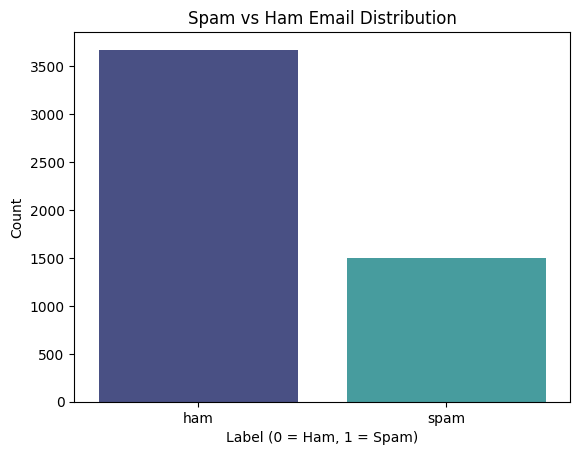

In [9]:
sns.countplot(x='label', data=df, palette='mako')
plt.title("Spam vs Ham Email Distribution")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

eda

In [10]:
df['label'] = df['label'].str.lower()   # make lowercase
df['label'] = df['label'].map({'ham':0, 'spam':1})  # convert to numeric

In [11]:
# Compute message length
df['text_length'] = df['text'].apply(len)

# Preview new feature
df[['text', 'text_length', 'label']].head()

,text,text_length,label
0,Subject: enron methanol ; meter # : 988291\r\n...,327,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",97,0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,0
3,"Subject: photoshop , windows , office . cheap ...",414,1
4,Subject: re : indian springs\r\nthis deal is t...,336,0


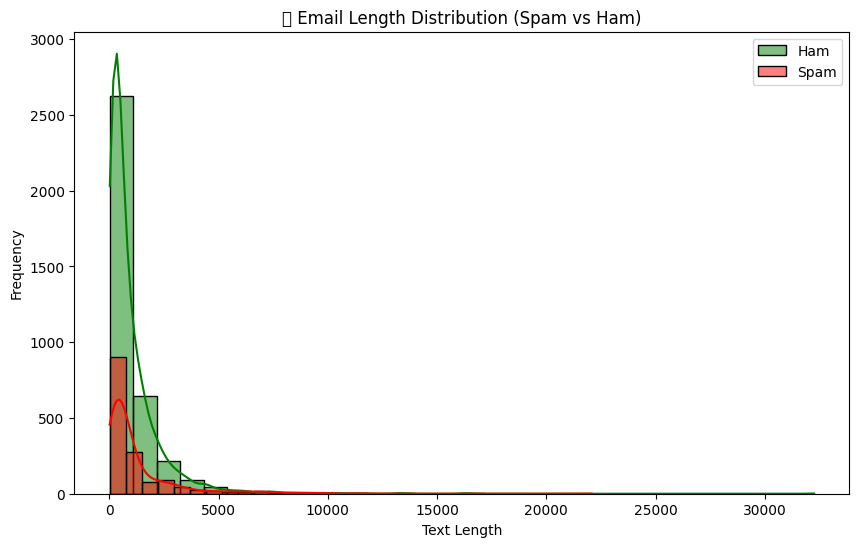

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['label']==0]['text_length'], bins=30, color='green', label='Ham', kde=True)
sns.histplot(df[df['label']==1]['text_length'], bins=30, color='red', label='Spam', kde=True)
plt.legend()
plt.title("📏 Email Length Distribution (Spam vs Ham)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [13]:
df.groupby('label')['text_length'].mean()

label
0     977.008170
1    1223.256171
Name: text_length, dtype: float64

In [14]:
# Example of spam and ham emails
print("Spam Email Example:\n", df[df['label']==1]['text'].iloc[0])
print("\n Ham Email Example:\n", df[df['label']==0]['text'].iloc[0])

Spam Email Example:
 Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin


 Ham Email Example:
 Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [15]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

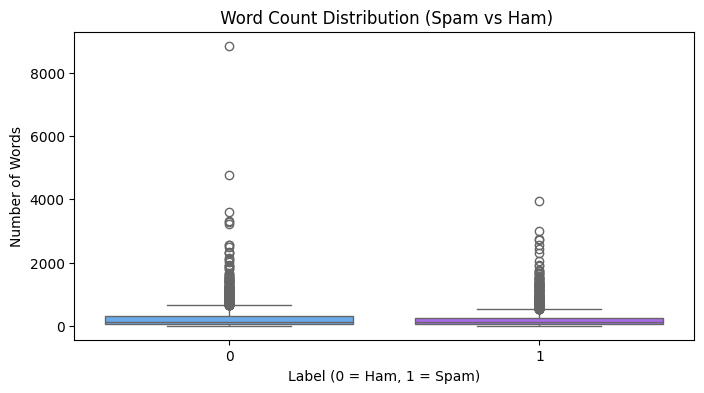

In [16]:
# Compare word counts
plt.figure(figsize=(8,4))
sns.boxplot(x='label', y='word_count', data=df, palette='cool')
plt.title(" Word Count Distribution (Spam vs Ham)")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Number of Words")
plt.show()

In [17]:
df.groupby('label')['word_count'].mean()

label
0    225.214325
1    234.077385
Name: word_count, dtype: float64

Tokenization

In [18]:
from collections import Counter
import re

In [19]:
def get_top_words(label, n=20):
    text = " ".join(df[df['label']==label]['text'])
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    return Counter(words).most_common(n)

In [20]:
# Top 20 words in spam and ham
spam_top = get_top_words(1)
ham_top = get_top_words(0)

In [21]:
print("Top Spam Words:", spam_top[:10])
print("Top Ham Words:", ham_top[:10])

Top Spam Words: [('the', 7254), ('and', 4903), ('you', 2794), ('for', 2523), ('this', 2283), ('your', 1946), ('subject', 1657), ('with', 1470), ('that', 1348), ('are', 1167)]
Top Ham Words: [('the', 18359), ('ect', 13897), ('for', 7982), ('and', 7912), ('hou', 7281), ('enron', 6555), ('subject', 6403), ('you', 5365), ('this', 4878), ('will', 3441)]


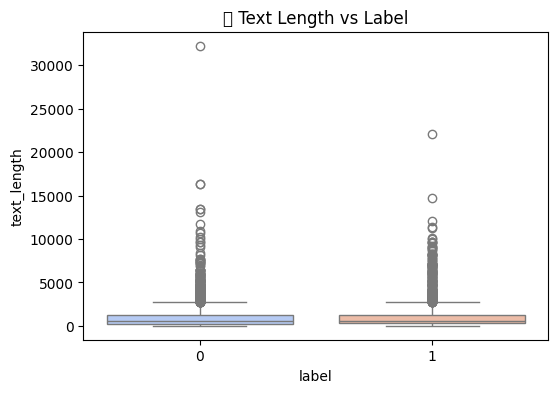

In [22]:
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='text_length', data=df, palette='coolwarm')
plt.title("📏 Text Length vs Label")
plt.show()

Data Preprocessing & Cleaning

In [23]:
# Create stemmer instance
stemmer = PorterStemmer()

# Get list of stopwords
stop_words = set(stopwords.words('english'))


In [24]:
def clean_email_text(text):
    # 1. Lowercase all text
    text = text.lower()

    # 2. Remove URLs, numbers, and special characters
    text = re.sub(r'http\S+|www\S+|[^a-z\s]', '', text)

    # 3. Tokenize text
    words = nltk.word_tokenize(text)

    # 4. Remove stopwords and apply stemming
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]

    # 5. Join back to a single string
    return " ".join(cleaned_words)

In [25]:
df['clean_text'] = df['text'].apply(clean_email_text)

In [26]:
df.head(3)

,Unnamed: 0,label,text,label_num,text_length,word_count,clean_text
0,605,0,Subject: enron methanol ; meter # : 988291\r\n...,0,327,67,subject enron methanol meter follow note gave ...
1,2349,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,23,subject hpl nom januari see attach file hplnol...
2,3624,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,550,subject neon retreat ho ho ho around wonder ti...


In [27]:
# Drop rows with empty clean_text
df = df[df['clean_text'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

In [28]:
df['clean_word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['clean_word_count'].describe()

count    5171.000000
mean       97.336685
std       149.798899
min         1.000000
25%        22.000000
50%        49.000000
75%       110.500000
max      3339.000000
Name: clean_word_count, dtype: float64

In [29]:
df['label'].value_counts()

label
0    3672
1    1499
Name: count, dtype: int64

Feature Extraction (Text Vectorization)

In [30]:
X = df['clean_text']   # Input features (cleaned email text)
y = df['label']        # Output label (0 = Ham, 1 = Spam)

In [31]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit to 5000 most frequent words

# Fit and transform the text data
X_tfidf = tfidf.fit_transform(X).toarray()

# Check shape
print("TF-IDF Matrix Shape:", X_tfidf.shape)

TF-IDF Matrix Shape: (5171, 5000)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

Before balancing:
label
0    2937
1    1199
Name: count, dtype: int64


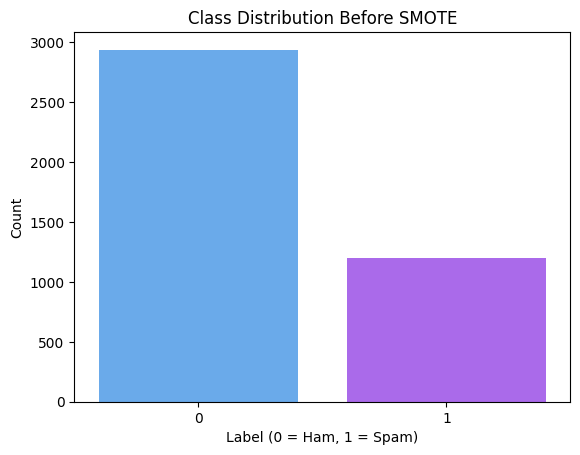

In [33]:
print("Before balancing:")
print(y_train.value_counts())

sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, palette='cool')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

After SMOTE:
label
1    2937
0    2937
Name: count, dtype: int64


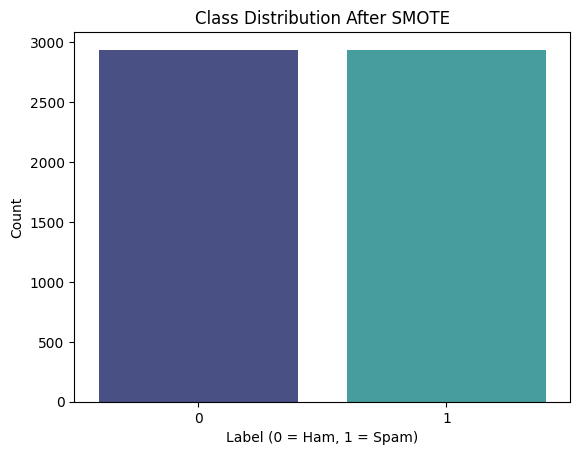

In [34]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on training data
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Check new balance
print("After SMOTE:")
print(y_train_bal.value_counts())

sns.barplot(x=y_train_bal.value_counts().index, y=y_train_bal.value_counts().values, palette='mako')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

In [35]:
print("X_train_bal shape:", X_train_bal.shape)
print("y_train_bal shape:", y_train_bal.shape)

X_train_bal shape: (5874, 5000)
y_train_bal shape: (5874,)


Model Building

In [36]:
# Initialize models
svm_model = LinearSVC()

In [37]:
svm_model.fit(X_train_bal, y_train_bal)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [38]:
svm_pred = svm_model.predict(X_test)

In [39]:
# Define a helper function
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 Model: {name}")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Ham', 'Spam']))


evaluate_model("Linear SVM", y_test, svm_pred)


📊 Model: Linear SVM
Accuracy: 0.9826

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       735
        Spam       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



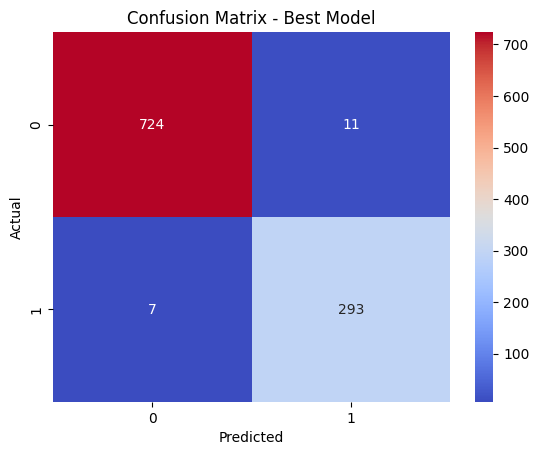

In [40]:
best_pred = svm_pred  # choose your best model manually after seeing results

cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Checking for overfitting

In [41]:
# Training accuracy
train_acc = svm_model.score(X_train_bal, y_train_bal)

# Test accuracy
test_acc = svm_model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Training Accuracy: 99.98%
Test Accuracy: 98.26%


In [42]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svm_model, X_tfidf, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.98647343 0.98742747 0.99032882 0.98162476 0.99226306]
Average CV Accuracy: 0.9876235061063923


Model Evaluation

In [43]:
# Predict labels for test data
y_pred = svm_model.predict(X_test)

In [44]:
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 Model Performance Summary")
print("----------------------------")
print(f"Accuracy:  {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall:    {rec*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")

📊 Model Performance Summary
----------------------------
Accuracy:  98.26%
Precision: 96.38%
Recall:    97.67%
F1 Score:  97.02%


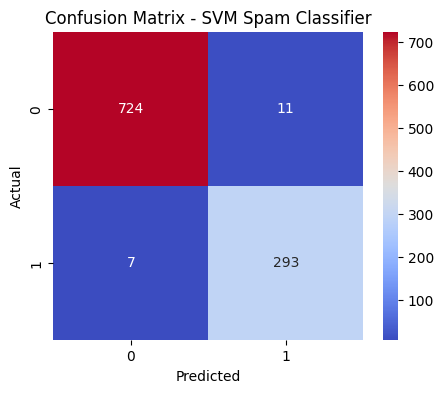

In [45]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - SVM Spam Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [46]:
print("Detailed Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Detailed Classification Report:

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       735
        Spam       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



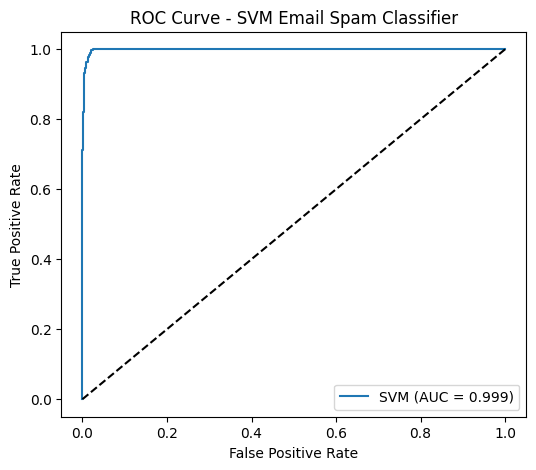

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get prediction probabilities (SVM doesn’t return by default, use decision_function)
y_scores = svm_model.decision_function(X_test)

# Compute ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_score:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - SVM Email Spam Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


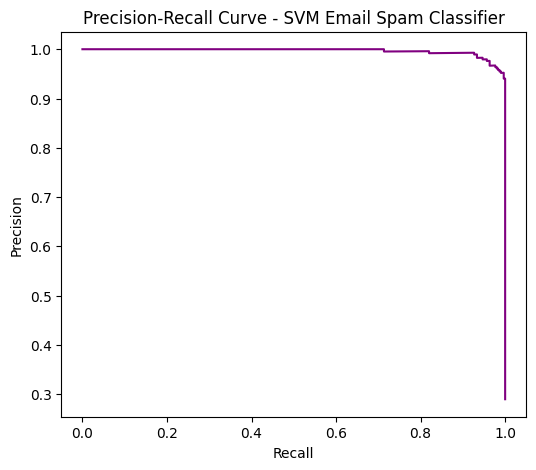

In [48]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple')
plt.title("Precision-Recall Curve - SVM Email Spam Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


Model Saving & Testing 

In [49]:
# Save the trained SVM model
pickle.dump(svm_model, open("svm_spam_model.pkl", "wb"))

# Save the TF-IDF vectorizer
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))

print("✅ Model and vectorizer saved successfully!")

✅ Model and vectorizer saved successfully!
